# Assignment 1 

# Data Set

### Getting GEDI Data (NASA)

In [7]:
import os
import h5py
import pandas as pd
from tqdm import tqdm

GEDI_FOLDER = './GEDI/'
OUTPUT_CSV = os.path.join(GEDI_FOLDER, 'gedi_canopy_height_andaman_final.csv')

all_gedi_data = []

try:
    gedi_files = [f for f in os.listdir(GEDI_FOLDER) if f.endswith('.h5')]
    if not gedi_files:
        exit()
except FileNotFoundError:
    exit()

for filename in tqdm(gedi_files, desc="Processing GEDI files", ncols=100, leave=True):
    filepath = os.path.join(GEDI_FOLDER, filename)
    
    try:
        with h5py.File(filepath, 'r') as hf:
            beams = [key for key in hf.keys() if key.startswith('BEAM')]
            
            for beam in beams:
                required_datasets = [
                    f'{beam}/lat_lowestmode', f'{beam}/lon_lowestmode',
                    f'{beam}/rh/rh100', f'{beam}/quality_flag', f'{beam}/sensitivity'
                ]
                if not all(d in hf for d in required_datasets):
                    continue

                quality_flag = hf[f'{beam}/quality_flag'][:]
                sensitivity = hf[f'{beam}/sensitivity'][:]
                
                valid_indices = (quality_flag == 1) & (sensitivity > 0.95)
                
                if valid_indices.any():
                    lats = hf[f'{beam}/lat_lowestmode'][:][valid_indices]
                    lons = hf[f'{beam}/lon_lowestmode'][:][valid_indices]
                    rh100 = hf[f'{beam}/rh/rh100'][:][valid_indices]
                    
                    beam_data = pd.DataFrame({
                        'latitude': lats,
                        'longitude': lons,
                        'canopy_height': rh100
                    })
                    all_gedi_data.append(beam_data)

    except Exception:
        continue

if all_gedi_data:
    gedi_df = pd.concat(all_gedi_data, ignore_index=True)
    gedi_df = gedi_df[gedi_df['canopy_height'] < 100] # Filter out unrealistic values
    gedi_df.to_csv(OUTPUT_CSV, index=False, float_format='%.6f')

print("\nThe data was saved under the GEDI dir")

Processing GEDI files: 100%|█████████████████████████████████████| 176/176 [00:00<00:00, 216.55it/s]


The data was saved under the GEDI dir


# CEDA


uses the rasterio and shapely libraries to clip a large virtual raster file (.vrt) to a specific geographic area defined by a bounding box. It creates a geometry object for the Andaman and Nicobar Islands, uses it as a mask to extract the corresponding raster data, and then saves this smaller, clipped section into a new GeoTIFF file

In [ ]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box

VRT_FILE = 'CEDA/biomass_mosaic.vrt'
OUTPUT_CLIPPED_FILE = 'biomass_andaman_nicobar_clipped.tif'

andaman_bounds = [92.1, 6.7, 94.3, 13.8]

try:
    bounding_box_geom = box(*andaman_bounds)
    
    with rasterio.open(VRT_FILE) as src:
        out_image, out_transform = mask(src, [bounding_box_geom], crop=True)
        out_meta = src.meta.copy()

    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(OUTPUT_CLIPPED_FILE, "w", **out_meta) as dest:
        dest.write(out_image)

except FileNotFoundError:
    print(f"Error: The virtual biomass file was not found. Please check the path: {VRT_FILE}")
except Exception as e:
    print(f"An error occurred during clipping: {e}")

--- Clipping CEDA/biomass_mosaic.vrt to the Andaman and Nicobar Islands ---
Performing clip operation...

Preprocessing complete!
Clipped biomass map saved to: biomass_andaman_nicobar_clipped.tif


the rasterio and pandas libraries to convert a GeoTIFF raster file (.tif) into a CSV file. It reads the image data into an array and iterates through each pixel. For every valid pixel (i.e., not a 'NoData' value), it converts the pixel's row and column coordinates into real-world geographic coordinates (longitude and latitude) and saves this information, along with the pixel's biomass value, into a final CSV file.

In [ ]:
import rasterio
import pandas as pd
from tqdm import tqdm

TIF_FILE = 'biomass_andaman_nicobar_clipped.tif'
OUTPUT_CSV = 'biomass_andaman_nicobar.csv'

pixel_data = []

try:
    with rasterio.open(TIF_FILE) as src:
        image_array = src.read(1)
        transform = src.transform
        nodata_value = src.nodata

        for row in tqdm(range(src.height), desc="Processing rows"):
            for col in range(src.width):
                biomass_value = image_array[row, col]
                
                if biomass_value != nodata_value:
                    lon, lat = transform * (col + 0.5, row + 0.5)
                    
                    pixel_data.append({
                        'longitude': lon,
                        'latitude': lat,
                        'biomass': biomass_value
                    })

    if pixel_data:
        df = pd.DataFrame(pixel_data)
        df.to_csv(OUTPUT_CSV, index=False)

except FileNotFoundError:
    print(f"Error: The TIF file was not found. Please check the path: {TIF_FILE}")
except Exception as e:
    print(f"An error occurred: {e}")

--- Converting biomass_andaman_nicobar_clipped.tif to biomass_andaman_nicobar.csv ---
Reading pixel data... (this may take a moment)


Processing rows: 100%|██████████| 7988/7988 [00:27<00:00, 287.14it/s]



Creating DataFrame...

Conversion complete! Data saved to 'biomass_andaman_nicobar.csv'
First 5 rows of the new CSV file:
   longitude   latitude  biomass
0  92.100000  13.799556        0
1  92.100889  13.799556        0
2  92.101778  13.799556        0
3  92.102667  13.799556        0
4  92.103556  13.799556        0


This script uses pandas to read a CSV file containing geospatial biomass data and matplotlib to create a spatial distribution map. It generates a scatter plot where each point's position is set by its longitude and latitude, and its color is determined by the biomass value. The final map is then saved as a high-resolution PNG image.

--- Plotting Biomass Distribution from biomass_andaman_nicobar.csv ---
Generating plot...

Plotting complete! Map saved to 'biomass_distribution_map.png'


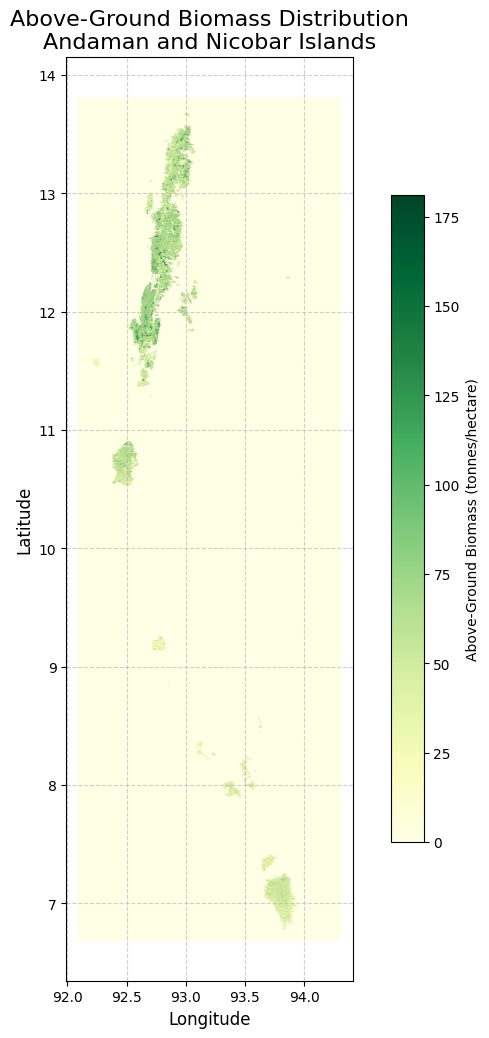

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# The preprocessed biomass CSV file
BIOMASS_CSV = 'biomass_andaman_nicobar.csv'
# The name for the output plot image
OUTPUT_PLOT = 'biomass_distribution_map.png'

print(f"--- Plotting Biomass Distribution from {BIOMASS_CSV} ---")

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(BIOMASS_CSV)

    # --- Data Cleaning (Optional but Recommended) ---
    # Remove any potential outlier or error values if necessary
    # For example, let's cap the biomass at a reasonable maximum for visualization
    df = df[df['biomass'] < 500] # Adjust this value as needed

    if df.empty:
        print("No data to plot after cleaning. Please check the CSV file.")
        exit()

    # --- Create the Plot ---
    print("Generating plot...")
    plt.figure(figsize=(10, 12))
    
    # Create a scatter plot:
    # x-axis is longitude, y-axis is latitude
    # c (color) is determined by the 'biomass' column
    # cmap is the color map (e.g., 'viridis', 'YlGn', 'jet')
    # s is the size of each point
    scatter = plt.scatter(
        df['longitude'], 
        df['latitude'], 
        c=df['biomass'], 
        cmap='YlGn',  # A good colormap for vegetation
        s=1          # Small point size for better detail
    )

    # --- Add Plot Details ---
    plt.title('Above-Ground Biomass Distribution\nAndaman and Nicobar Islands', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box') # Ensure correct map scaling

    # Add a color bar to show what the colors mean
    cbar = plt.colorbar(scatter, shrink=0.7, label='Above-Ground Biomass (tonnes/hectare)')

    # --- Save the Plot ---
    plt.savefig(OUTPUT_PLOT, dpi=300, bbox_inches='tight')
    
    print(f"\nPlotting complete! Map saved to '{OUTPUT_PLOT}'")
    

except FileNotFoundError:
    print(f"Error: The biomass CSV file was not found. Please check the path: {BIOMASS_CSV}")
except Exception as e:
    print(f"An error occurred: {e}")

# GEDI

In [10]:
import os
import h5py
import pandas as pd
from tqdm import tqdm

GEDI_FOLDER = './GEDI/'
OUTPUT_CSV = 'canopy_andaman_nicobar.csv'

all_gedi_data = []

try:
    gedi_files = [f for f in os.listdir(GEDI_FOLDER) if f.endswith('.h5')]
except FileNotFoundError:
    gedi_files = []

for filename in tqdm(gedi_files, desc="Processing GEDI files", ncols=100, leave=False):
    filepath = os.path.join(GEDI_FOLDER, filename)
    
    try:
        with h5py.File(filepath, 'r') as hf:
            beams = [key for key in hf.keys() if key.startswith('BEAM')]
            
            for beam in beams:
                required_datasets = [
                    f'{beam}/lat_lowestmode', f'{beam}/lon_lowestmode',
                    f'{beam}/rh/rh100', f'{beam}/quality_flag', f'{beam}/sensitivity'
                ]
                if not all(d in hf for d in required_datasets):
                    continue

                quality_flag = hf[f'{beam}/quality_flag'][:]
                sensitivity = hf[f'{beam}/sensitivity'][:]
                
                valid_indices = (quality_flag == 1) & (sensitivity > 0.95)
                
                if valid_indices.any():
                    lats = hf[f'{beam}/lat_lowestmode'][:][valid_indices]
                    lons = hf[f'{beam}/lon_lowestmode'][:][valid_indices]
                    rh100 = hf[f'{beam}/rh/rh100'][:][valid_indices]
                    
                    beam_data = pd.DataFrame({
                        'latitude': lats,
                        'longitude': lons,
                        'canopy_height': rh100
                    })
                    all_gedi_data.append(beam_data)
    except Exception:
        continue

if all_gedi_data:
    gedi_df = pd.concat(all_gedi_data, ignore_index=True)
    gedi_df = gedi_df[(gedi_df['canopy_height'] < 100) & (gedi_df['canopy_height'] > 0)]
    if not gedi_df.empty:
        gedi_df.to_csv(OUTPUT_CSV, index=False, float_format='%.6f')

print("the csv file is written")

Processing GEDI files:   0%|                                                | 0/176 [00:00<?, ?it/s]

the csv file is written


## Map


Plot saved successfully to 'canopy_height_map.png'


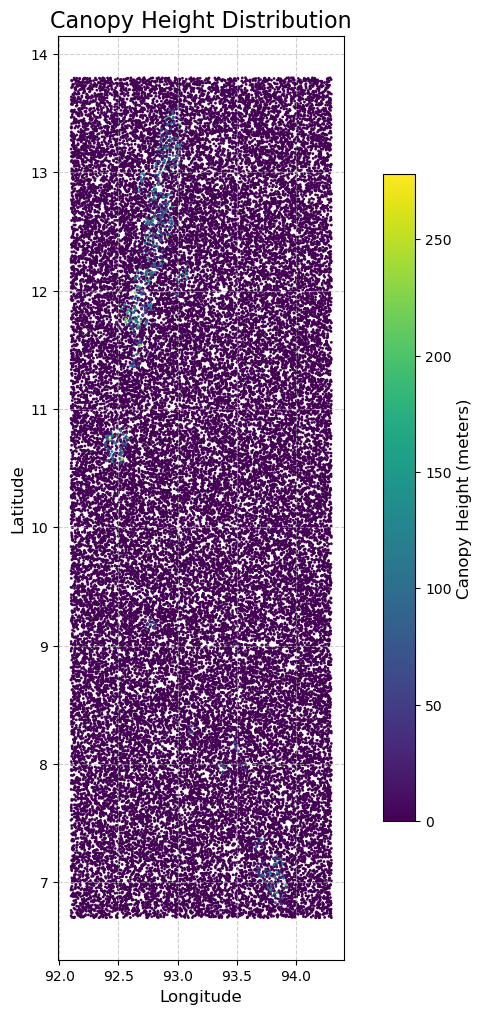

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV = 'canopy_andaman_nicobar.csv'
OUTPUT_PLOT = 'canopy_height_map.png'

try:
    df = pd.read_csv(INPUT_CSV)
    
    plot_df = df.dropna(subset=['longitude', 'latitude', 'canopy_height'])

    if plot_df.empty:
        print("No valid data found in the CSV file to plot.")
        exit()

    sample_size = 50000
    if len(plot_df) > sample_size:
        plot_df = plot_df.sample(n=sample_size, random_state=42)

    plt.figure(figsize=(10, 12))
    
    scatter = plt.scatter(
        plot_df['longitude'], 
        plot_df['latitude'], 
        c=plot_df['canopy_height'], 
        cmap='viridis',
        s=1
    )
    
    plt.title('Canopy Height Distribution', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    
    cbar = plt.colorbar(scatter, shrink=0.7)
    cbar.set_label('Canopy Height (meters)', fontsize=12)
    
    plt.savefig(OUTPUT_PLOT, dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully to '{OUTPUT_PLOT}'")
    
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{INPUT_CSV}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


# Correlation Analysis


--- Correlation Analysis ---
Spearman's Correlation Coefficient: 0.8023
P-value: 0.0

Plot saved successfully to 'canopy_vs_biomass_correlation.png'


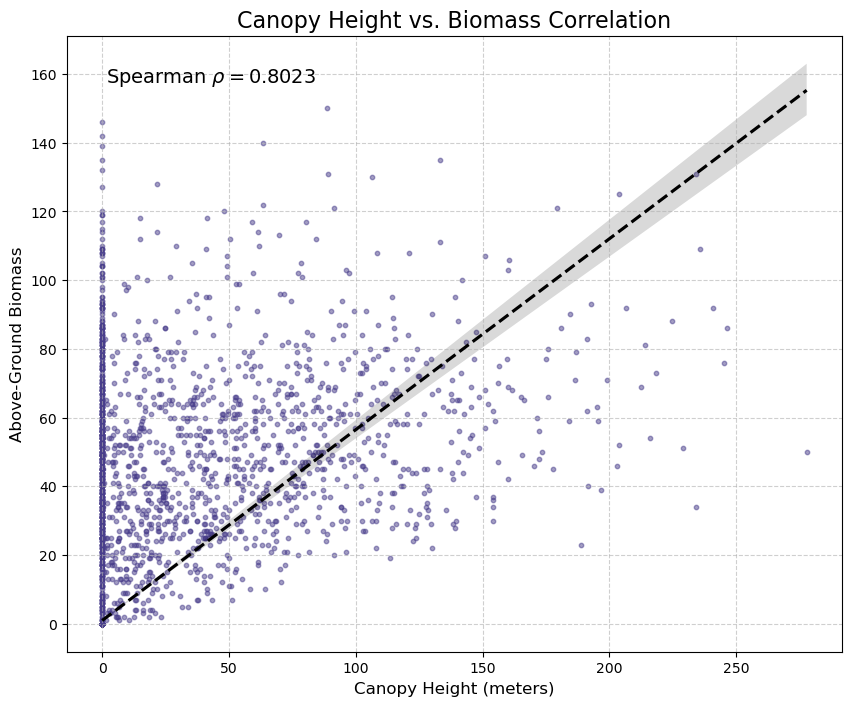

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

CANOPY_CSV = 'canopy_andaman_nicobar.csv'
BIOMASS_CSV = 'biomass_andaman_nicobar.csv'
OUTPUT_PLOT = 'canopy_vs_biomass_correlation.png'

try:
    canopy_cols_to_use = ['latitude', 'longitude', 'canopy_height']
    df_canopy = pd.read_csv(CANOPY_CSV, usecols=canopy_cols_to_use)
    df_biomass = pd.read_csv(BIOMASS_CSV)

    df_canopy.columns = df_canopy.columns.str.strip()
    df_biomass.columns = df_biomass.columns.str.strip()

    precision = 6
    df_biomass['latitude'] = df_biomass['latitude'].round(precision)
    df_biomass['longitude'] = df_biomass['longitude'].round(precision)
    df_canopy['latitude'] = df_canopy['latitude'].round(precision)
    df_canopy['longitude'] = df_canopy['longitude'].round(precision)

    df_merged = pd.merge(df_biomass, df_canopy, on=['latitude', 'longitude'])
    df_merged.dropna(subset=['biomass', 'canopy_height'], inplace=True)
    
    if df_merged.empty:
        print("No matching data found after merging the files.")
        exit()

    corr, p_value = spearmanr(df_merged['biomass'], df_merged['canopy_height'])
    
    print(f"--- Correlation Analysis ---")
    print(f"Spearman's Correlation Coefficient: {corr:.4f}")
    print(f"P-value: {p_value}")

    sample_size = 50000
    if len(df_merged) > sample_size:
        plot_df = df_merged.sample(n=sample_size, random_state=42)
    else:
        plot_df = df_merged

    plt.figure(figsize=(10, 8))
    sns.regplot(
        x='canopy_height', 
        y='biomass', 
        data=plot_df,
        scatter_kws={'alpha': 0.5, 's': 10, 'color': 'darkslateblue'},
        line_kws={'color': 'black', 'linestyle': '--'}
    )
    
    plt.title('Canopy Height vs. Biomass Correlation', fontsize=16)
    plt.xlabel('Canopy Height (meters)', fontsize=12)
    plt.ylabel('Above-Ground Biomass', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.text(0.05, 0.95, f'Spearman $\\rho = {corr:.4f}$',
             transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top')
    
    plt.savefig(OUTPUT_PLOT, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved successfully to '{OUTPUT_PLOT}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Linear Regression

--- Starting Linear Regression Analysis ---
Loading and merging data files...
Splitting data into training and testing sets...
Training the linear regression model...
Evaluating the model on the test set...

--- Model Results ---
Model Equation: biomass = 0.18 * canopy_height + 39.48
R-squared (R²): 0.1111
Root Mean Squared Error (RMSE): 24.74

Generating plot...
Plot saved successfully to 'linear_regression_fit.png'


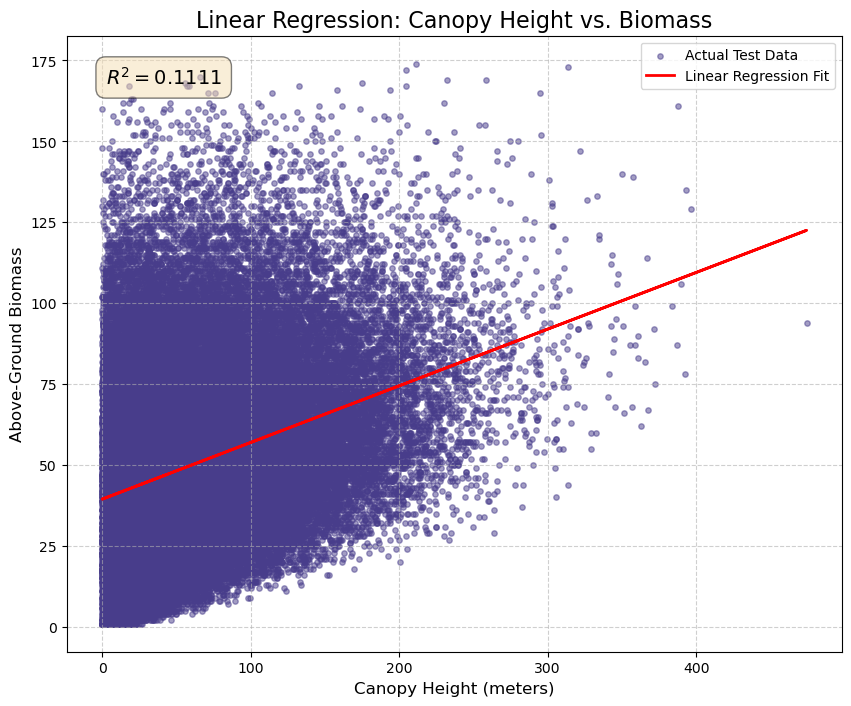

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- Configuration ---
CANOPY_CSV = 'canopy_andaman_nicobar.csv'
BIOMASS_CSV = 'biomass_andaman_nicobar.csv'
OUTPUT_PLOT = 'linear_regression_fit.png'

print("--- Starting Linear Regression Analysis ---")

try:
    # --- 1. Load and Prepare Data ---
    print("Loading and merging data files...")
    df_canopy = pd.read_csv(CANOPY_CSV, usecols=['latitude', 'longitude', 'canopy_height'])
    df_biomass = pd.read_csv(BIOMASS_CSV)

    # Clean column names
    df_canopy.columns = df_canopy.columns.str.strip()
    df_biomass.columns = df_biomass.columns.str.strip()

    # Round coordinates to ensure a successful merge
    precision = 6
    for df in [df_biomass, df_canopy]:
        df['latitude'] = df['latitude'].round(precision)
        df['longitude'] = df['longitude'].round(precision)

    df_merged = pd.merge(df_biomass, df_canopy, on=['latitude', 'longitude'])
    
    # Remove rows where target or feature is missing or zero (for better model fit)
    df_merged.dropna(subset=['biomass', 'canopy_height'], inplace=True)
    df_merged = df_merged[(df_merged['biomass'] > 0) & (df_merged['canopy_height'] > 0)]

    if df_merged.empty:
        print("No matching data found after merging and cleaning. Exiting.")
        exit()

    # --- 2. Define Features and Target & Split Data ---
    print("Splitting data into training and testing sets...")
    # We want to predict 'biomass' from 'canopy_height'
    X = df_merged[['canopy_height']]  # Feature (needs to be 2D)
    y = df_merged['biomass']          # Target

    # Split into 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- 3. Train the Linear Regression Model ---
    print("Training the linear regression model...")
    model = LinearRegression()
    model.fit(X_train, y_train)

    # --- 4. Evaluate the Model ---
    print("Evaluating the model on the test set...")
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Get model coefficients
    intercept = model.intercept_
    coefficient = model.coef_[0]

    print("\n--- Model Results ---")
    print(f"Model Equation: biomass = {coefficient:.2f} * canopy_height + {intercept:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    # --- 5. Visualize the Results ---
    print("\nGenerating plot...")
    plt.figure(figsize=(10, 8))
    
    # Scatter plot of the actual test data
    plt.scatter(X_test, y_test, alpha=0.5, s=15, label='Actual Test Data', color='darkslateblue')
    
    # Plot the regression line
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Linear Regression Fit')
    
    plt.title('Linear Regression: Canopy Height vs. Biomass', fontsize=16)
    plt.xlabel('Canopy Height (meters)', fontsize=12)
    plt.ylabel('Above-Ground Biomass', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add R-squared value to the plot
    plt.text(0.05, 0.95, f'$R^2 = {r2:.4f}$',
             transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
    
    plt.savefig(OUTPUT_PLOT, dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully to '{OUTPUT_PLOT}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")